# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 0. Импорт библиотек и функций

In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade Pillow -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ydata_profiling==4.5.1 -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.4.0 requires ipykernel, which is not installed.
qtconsole 5.3.2 requires ipykernel>=4.1, which is not installed.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.23.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install -U scikit-learn -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [5]:
pip install category_encoders -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import lightgbm as lgm
import sklearn
from numpy import sqrt
import time
import phik

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [7]:
RANDOM_STATE = 42
VALID_SIZE = 0.1

In [8]:
#Функция для анализа категоральных столбцов. Строит гистограмму и выводит отношение значений (без учета np.nan)

def cat_col_analiz(data, col, val_show='on', hue='off', discrete=False, common_norm=False):
    sn.set_palette('Set2')
    plt.subplots(figsize=(12, 6))
    if hue=='off':
        sn.histplot(data.dropna(), x=col)
    if hue != 'off':
        sn.histplot(data.dropna(), x=col, hue=hue, multiple='stack', discrete=discrete, common_norm=common_norm)
    plt.title(label = f'Гистограмма для показателя {col}\nБез учета значений np.nan\n', fontsize=15)
    plt.xlabel(col, fontsize=15)
    plt.xticks(rotation=45,fontsize=10)
    plt.ylabel('Количество', fontsize=15)
    plt.show()
    if val_show == 'on':
        print(f'{data[col].value_counts(normalize=True)}\n{data[col].value_counts()}')
    print('\n')

In [9]:
#Функция для исследовательского анализа количественных признаков. Строит диаграмму размаха,
#показывает список и количество выбросов, при их присутствии 

def num_col_analiz(data, col):
    sn.set_palette('Set2')
    plt.subplots(figsize=(10, 2))
    sn.boxplot(data=data[col], orient='h');
    plt.title(label = f'Диаграмма размаха для показателя {col}', fontsize=15)
    plt.show()
    extum_list_max=[] #Список для выбросов "справа"
    extum_list_min=[] #Список для выбросов "слева"
    Q3 = data[col].describe().loc['75%'] #Фиксируем значение третьего квартиля
    Q1 = data[col].describe().loc['25%'] #Фиксируем значение первого квартиля
    IQR = Q3-Q1  #Находим межквартильный размах
    for i in data[col]: #Находим экстремумные значения - "выбросы" и раскидываем их по спискам
        if i < (Q1 - IQR * 1.5):
            extum_list_min.append(i)
        if i > (Q3 + IQR * 1.5):
            extum_list_max.append(i)
    col_size = len(data[col])
    extum_list_min = sorted(extum_list_min)
    extum_list_max = sorted(extum_list_max)
    min_len = len(extum_list_min)
    max_len = len(extum_list_max)
    print(data[col].describe().T)
    print('\n')
    print(f'Выбросы ниже нормальных значений: \nКоличество выбросов: {min_len} \nПроцент выбросов: {round((min_len / col_size) * 100,2)} %')
    print('\n')
    print(f'Выбросы выше нормальных значений: \nКоличество выбросов: {max_len} \nПроцент выбросов: {round((max_len / col_size) * 100,2)} %')
    print('\n')
    print(f'Выбросы ниже нормальных значений: {extum_list_min}\n')
    print(f'Выбросы выше нормальных значений: {extum_list_max}\n')

## 1.Загрузка датасета

**Загружаем данные в датасет auto_data**

In [10]:
auto_data = pd.read_csv('/datasets/autos.csv')

In [11]:
auto_data_size = auto_data.shape[0] #Сохраним для статистики изначальный размер датасета

In [12]:
auto_data_size

354369

In [13]:
auto_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Данные загружены корректно**

## 2.Исследовательский анализ

**Изучим общую статистику по датасету**

In [14]:
auto_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [15]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Названия колонок в едином формате, тип данных в колонках соответствуют их логическому наполнению. При дальнейшей подготовке данных для обучения модели, формат столбцов возможно будет изменен**

**-----------------------------------------------**

**-----------------------------------------------**

**Проверим корреляцию признаков между собой**

Такие признаки как:
* 'NumberOfPictures',
* 'DateCrawled',
* 'LastSeen',
* 'PostalCode',
* 'DateCreated'

учитывать не будем, так как они не относятся напрямую к обьектам исследования (автомобилям)

In [16]:
intervals_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

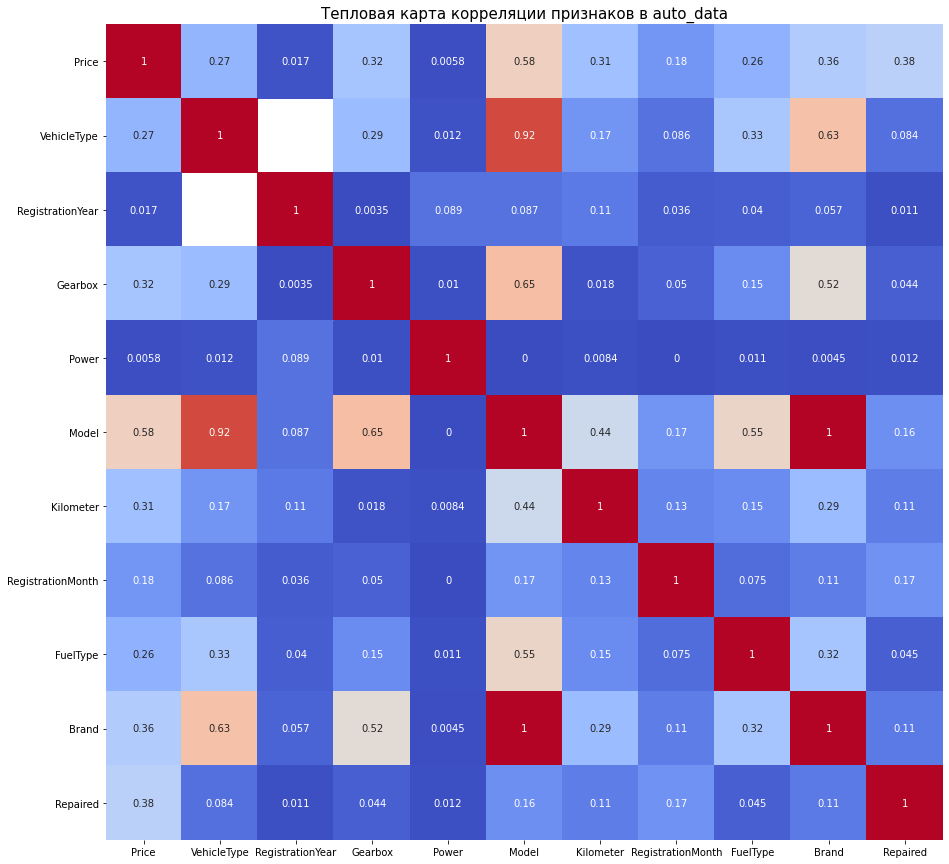

In [17]:
plt.subplots(figsize=(15, 15))
plt.title(label = 'Тепловая карта корреляции признаков в auto_data', fontsize=15)
sn.heatmap(auto_data.drop(['NumberOfPictures','DateCrawled','LastSeen','PostalCode','DateCreated'],axis=1).phik_matrix(interval_cols=intervals_cols), cmap="coolwarm", cbar=False, annot=True);

Наблюдаем очень высокую мультиколлинеарность между такими признаками как 
* **Brand** и **Model** - 1
* **Model** и **VehicleType** - 0.92

Тк обе пары объединяет признак Model, то его исключим из данных для работы с моделями

**Для работы с моделями и предсказанием цены оставим следующие входящие признаки:**

* VehicleType
* RegistrationYear
* Gearbox
* Power
* Kilometer
* FuelType
* Brand
* Repaired

**Price - остается таргетом**

Всего 9 признаков

In [18]:
features = ['VehicleType','RegistrationYear','Gearbox','Power','Kilometer','FuelType','Brand','Repaired'] #Создадим список столбцов дадасета, которые будут иметь значение и использоваться для работы с моделями

**----------------------------------------------------------**

**----------------------------------------------------------**

### 2.1 Явные дубликаты

In [19]:
auto_data.duplicated().sum()

4

In [20]:
auto_data.drop_duplicates(inplace=True, keep='first')

In [21]:
auto_data.duplicated().sum()

0

**В датасете присутствовало 4 явных дубликата, которые были удалены**

**----------------------------------------------------------**

**----------------------------------------------------------**

### 2.2 Пропуски

**Проверим пропуски в датасете и анамальные значения**

In [22]:
miss_list = [] #Создадим список в который занесем названия "неполных" колонок

In [23]:
for col in ['VehicleType','RegistrationYear','Gearbox','Power','Kilometer','FuelType','Brand','Repaired','Price']:
    col_miss_val = auto_data[col].isna().sum()
    if col_miss_val > 0:
        miss_list.append(col)
    print(f'Колонка {col}')
    print(f'Количество пропусков {col_miss_val}')
    print(f'Процент пропусков {round(auto_data[col].isna().mean() * 100,2)}%')
    print(f'Количество уникальных значений {len(auto_data[col].unique())}\n')

Колонка VehicleType
Количество пропусков 37490
Процент пропусков 10.58%
Количество уникальных значений 9

Колонка RegistrationYear
Количество пропусков 0
Процент пропусков 0.0%
Количество уникальных значений 151

Колонка Gearbox
Количество пропусков 19833
Процент пропусков 5.6%
Количество уникальных значений 3

Колонка Power
Количество пропусков 0
Процент пропусков 0.0%
Количество уникальных значений 712

Колонка Kilometer
Количество пропусков 0
Процент пропусков 0.0%
Количество уникальных значений 13

Колонка FuelType
Количество пропусков 32895
Процент пропусков 9.28%
Количество уникальных значений 8

Колонка Brand
Количество пропусков 0
Процент пропусков 0.0%
Количество уникальных значений 40

Колонка Repaired
Количество пропусков 71154
Процент пропусков 20.08%
Количество уникальных значений 3

Колонка Price
Количество пропусков 0
Процент пропусков 0.0%
Количество уникальных значений 3731



**Столбцы с пропусками:**

In [24]:
miss_list

['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

**----------------------------------------------------------**

**----------------------------------------------------------**

### Repaired

In [25]:
auto_data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Колонка Repaired содержит больше 20% пропусков, слишком большое количество пропусков для удаления данных. Предположим, что при отсутствии ремонта, человек заполняющий данные об авто просто пропускал этот столбец. Следовательно все значения nan заменим на **no**

In [26]:
auto_data['Repaired'] = auto_data['Repaired'].fillna('maybe')

In [27]:
auto_data['Repaired'].unique()

array(['maybe', 'yes', 'no'], dtype=object)

In [28]:
auto_data['Repaired'].isna().sum()

0

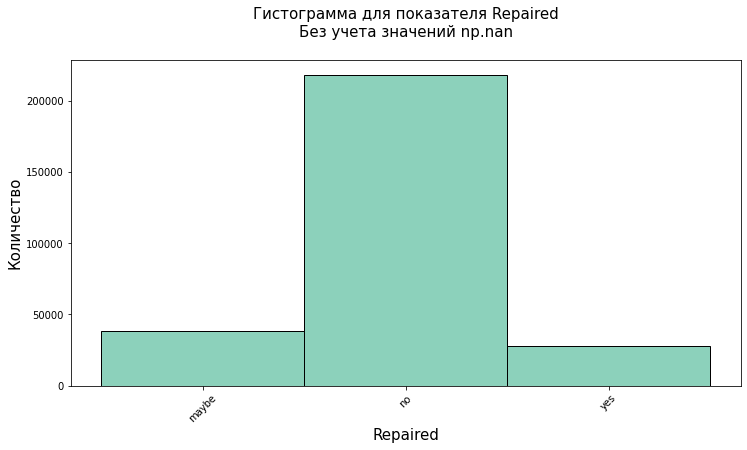

no       0.697467
maybe    0.200793
yes      0.101740
Name: Repaired, dtype: float64
no       247158
maybe     71154
yes       36053
Name: Repaired, dtype: int64




In [29]:
cat_col_analiz(auto_data, 'Repaired')

**----------------------------------------------------------**

### Brand

In [30]:
auto_data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Пропусков нет, значний типа nan тоже нет. Все впорядке

### FuelType

In [31]:
auto_data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

petrol и gasoline это одно и тоже топливо, приведем к единому стандарту

In [32]:
auto_data['FuelType'] = auto_data['FuelType'].replace('gasoline','petrol')

**Как мы помним в столбце FuelType 9.28% пропусков. Заполним их по моде для каждой модели**

In [33]:
brands = auto_data['Brand'].unique().tolist()

**Пропуски в моделях заполним по моде для каждого конкретного бренда**

Если для бренда неизвестно ниодной модели, то заменим значение NaN на Unknown

In [34]:
for brand in brands:
    x_mode = auto_data[auto_data['Brand']==brand]['Model'].mode()
    try:
        auto_data.loc[(auto_data['Model'].isna()) & (auto_data['Brand']==brand),'Model'] = x_mode[0]
    except:
        auto_data.loc[(auto_data['Model'].isna())&(auto_data['Brand']==brand),'Model'] = 'unknown'

In [35]:
auto_data['Model'].isna().sum()

0

**Пропусков в Моделях больше нет**

**---------------------------------------------**

**---------------------------------------------**

**Заполним пропуски в типе топлива по моде для каждой конкретной модели**

Если для модели неизвестно ниодного типа топлива, то заменим пропуск на unknown

In [36]:
models = auto_data['Model'].unique().tolist()

In [37]:
for model in models:
    x_mode = auto_data[auto_data['Model']==model]['FuelType'].mode()
    try:
        auto_data.loc[(auto_data['FuelType'].isna()) & (auto_data['Model']==model),'FuelType'] = x_mode[0]
    except:
        auto_data.loc[(auto_data['FuelType'].isna()) & (auto_data['Model']==model),'FuelType'] = 'unknown'

In [38]:
auto_data['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

**Пропусков в типе топлива больше нет**

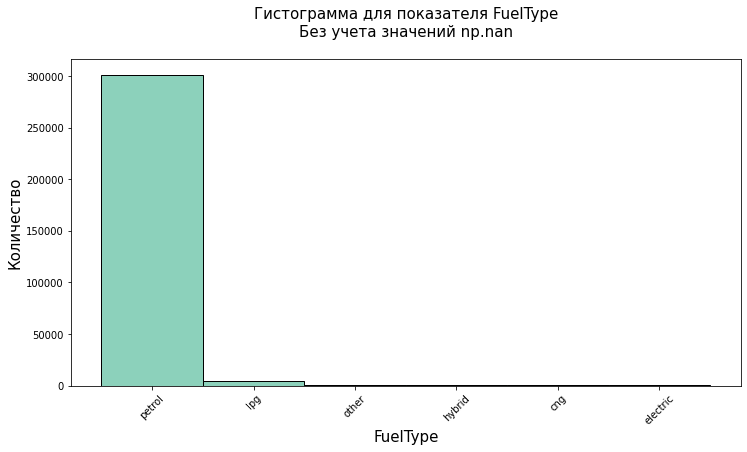

petrol      0.981934
lpg         0.014985
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64
petrol      347963
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64




In [39]:
cat_col_analiz(auto_data, 'FuelType')

**---------------------------------------------**

**---------------------------------------------**

### Gearbox

In [40]:
auto_data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

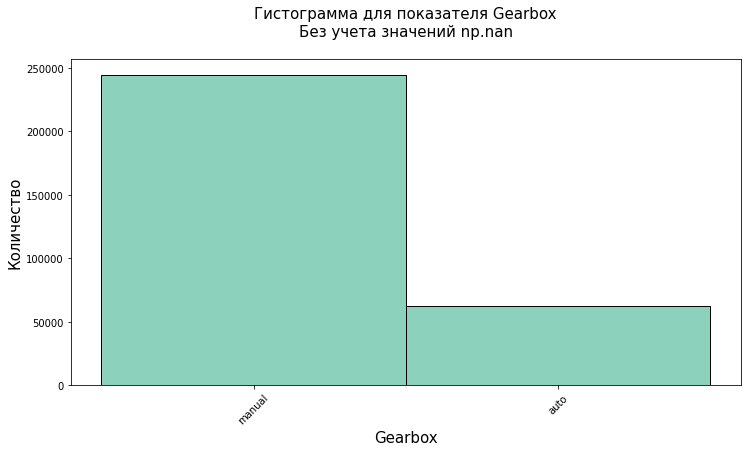

manual    0.801863
auto      0.198137
Name: Gearbox, dtype: float64
manual    268249
auto       66283
Name: Gearbox, dtype: int64




In [41]:
cat_col_analiz(auto_data, 'Gearbox')

**Как мы знаем, в Gearbox 5.6% пропусков**

Заполним так же по моде для каждой модели, если для модели неизвестен тип коробки, поставим значение uknown

In [42]:
for model in models:
    x_mode = auto_data[auto_data['Model']==model]['Gearbox'].mode()
    try:
        auto_data.loc[(auto_data['Gearbox'].isna()) & (auto_data['Model']==model),'Gearbox'] = x_mode[0]
    except:
        auto_data.loc[(auto_data['Gearbox'].isna()) & (auto_data['Model']==model),'Gearbox'] = 'unknown'

In [43]:
auto_data['Gearbox'].isna().sum()

0

**Пропусков в Gearbox больше нет**

**------------------------------------------------**

**-------------------------------------------------**

### VehicleType

In [44]:
auto_data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

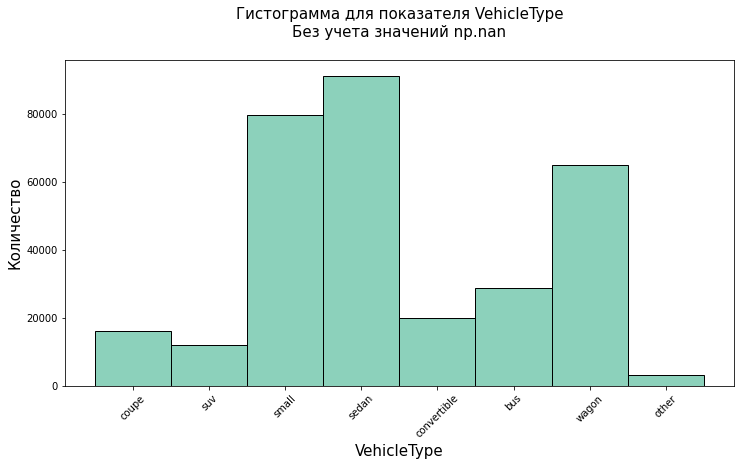

sedan          0.288622
small          0.251929
wagon          0.205649
bus            0.090809
convertible    0.063757
coupe          0.051001
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64




In [45]:
cat_col_analiz(auto_data, 'VehicleType')

**Как мы знаем в VehicleType 10.58% пропусков, заполним признак по аналогии с предыдущими**

In [46]:
for model in models:
    x_mode = auto_data[auto_data['Model']==model]['VehicleType'].mode()
    try:
        auto_data.loc[(auto_data['VehicleType'].isna()) & (auto_data['Model']==model),'VehicleType'] = x_mode[0]
    except:
        auto_data.loc[(auto_data['VehicleType'].isna()) & (auto_data['Model']==model),'VehicleType'] = 'unknown'

In [47]:
auto_data['VehicleType'].isna().sum()

0

**Пропусков в Gearbox больше нет**

**------------------------------------------------**

**------------------------------------------------**

### Все пропуски закончились. Ниже исследуются признаки, в которых нет пропусков, но могут быть аномальные данные

### 2.3 Аномальные значения

### RegistrationYear

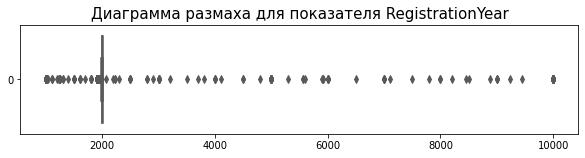

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


Выбросы ниже нормальных значений: 
Количество выбросов: 6204 
Процент выбросов: 1.75 %


Выбросы выше нормальных значений: 
Количество выбросов: 105 
Процент выбросов: 0.03 %


Выбросы ниже нормальных значений: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1039, 1111, 1111, 1111, 1200, 1234, 1234, 1234, 1234, 1253, 1255, 1300, 1300, 1400, 1500, 1500, 1500, 1500, 1500, 1600, 1600, 1602, 1688, 1800, 1800, 1800, 1800, 1800, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910, 1910,

In [48]:
num_col_analiz(auto_data,'RegistrationYear')

Алгоритм выделил выбросы. 

К "правым" выбросам вопросов нет, машины 2066 года выпуска и современнее - явно анамалии и ошибки в заполнении данных.
С "левыми" не все так однозначно, все таки машины около 1985 года выпуска это не что то фантастическое, но таких значений всего 1.75% и врядли кто то рассматривает такие авто к покупке, так что думаю такими данными можно так же принебречь и удалить их из датасета. Т.к датасет 2016 года, удалим все записи "новее" 2016 года

In [49]:
reg_mask = (auto_data['RegistrationYear']>=2017) | (auto_data['RegistrationYear']<= 1985)

In [50]:
auto_data = auto_data.drop(auto_data[reg_mask].index)

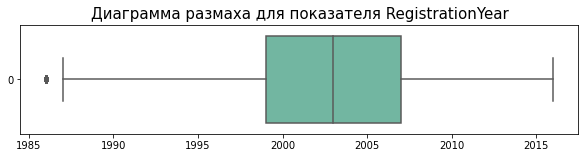

count    333631.000000
mean       2002.994557
std           5.823445
min        1986.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


Выбросы ниже нормальных значений: 
Количество выбросов: 538 
Процент выбросов: 0.16 %


Выбросы выше нормальных значений: 
Количество выбросов: 0 
Процент выбросов: 0.0 %


Выбросы ниже нормальных значений: [1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 198

In [51]:
num_col_analiz(auto_data,'RegistrationYear') #Проверяем еще раз

**Выбросы и аномалии удалены**

**-------------------------------------------**

**-------------------------------------------**

### RegistrationMonth

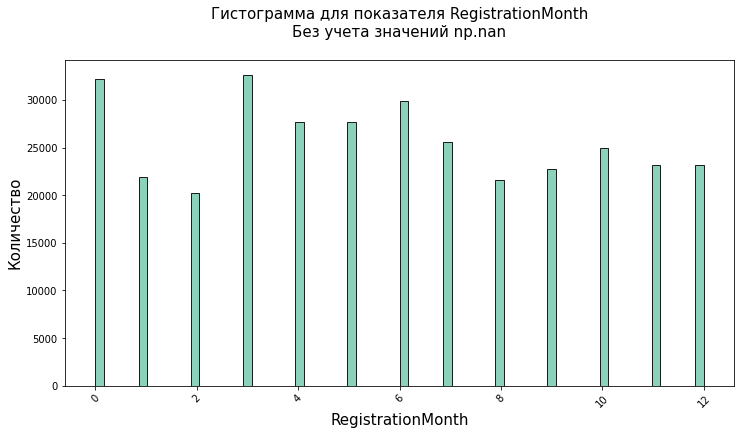

3     0.097776
0     0.096478
6     0.089623
4     0.083119
5     0.082981
7     0.076809
10    0.074954
12    0.069586
11    0.069478
9     0.068294
1     0.065653
8     0.064658
2     0.060591
Name: RegistrationMonth, dtype: float64
3     32621
0     32188
6     29901
4     27731
5     27685
7     25626
10    25007
12    23216
11    23180
9     22785
1     21904
8     21572
2     20215
Name: RegistrationMonth, dtype: int64




In [52]:
cat_col_analiz(auto_data,'RegistrationMonth')

Регистрация 0 месяц - аномалия, удаляем, тк чем заменить угадать не можем.

In [53]:
mnt_mask = auto_data['RegistrationMonth']==0

In [54]:
auto_data = auto_data.drop(auto_data[mnt_mask].index)

**-------------------------------------------**

**-------------------------------------------**

### Power

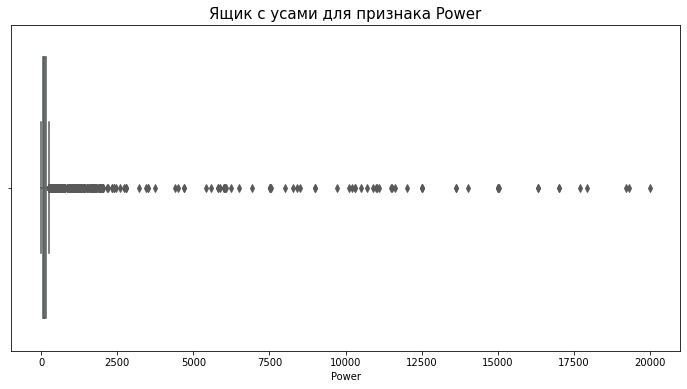

In [55]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.boxplot(x = auto_data['Power']);
plt.title(label=f'Ящик с усами для признака Power', fontsize=15);
plt.show()

Алгоритм выделил выбросы.

С "левой стороны" выбросов нет совсем.
С "правой стороны" 2.07% выбросов, но при рассмотрении видим, что алгоритм оценил как выбросы даже весьма обычные значения в 250+ лс. Да, конечно появляются вопросы к 1000+, возможно на продажу стоит парочка Бугатти:)
Посмотрим что там

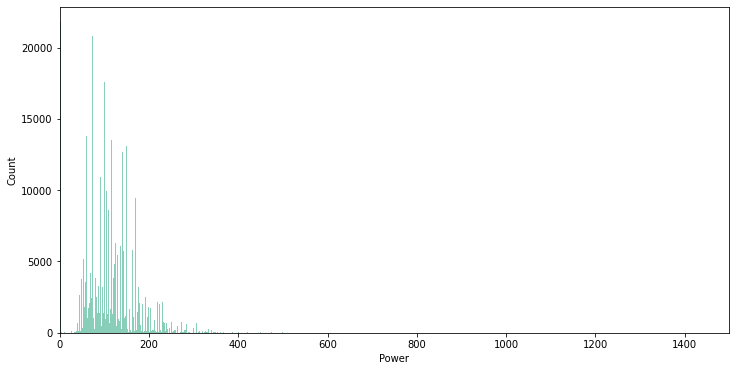

In [56]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.histplot(data=auto_data['Power']);
plt.xlim(0, 1500)
plt.show()

Широнов нет. Удаляем все "правые" выбросы. Оставим более приземленные значения до 400 лс, которые еще как то заметны на гистограмме

In [57]:
pow_mask = auto_data['Power']>400

In [58]:
auto_data = auto_data.drop(auto_data[pow_mask].index)

**Так же смущает минимальное значение мощности в 0 л.с**

Посмотрим как примерно выглядит гистограмма мощностей

**Какие то более-менее заметные всплески начинаются с около 40 л.с.**
**Все что ниже удалим как аномалии.**

In [59]:
pow_mask = auto_data['Power']<40

In [60]:
auto_data = auto_data.drop(auto_data[pow_mask].index)

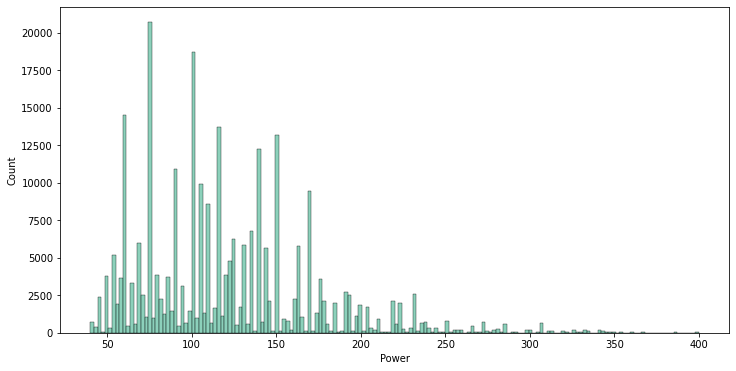

In [61]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.histplot(data=auto_data['Power']);
plt.show()

**Получше**

**----------------------------------------------------------**

**----------------------------------------------------------**

### Kilometer

In [62]:
auto_data['Kilometer'].describe().T

count    278364.000000
mean     128378.076906
std       36437.178991
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

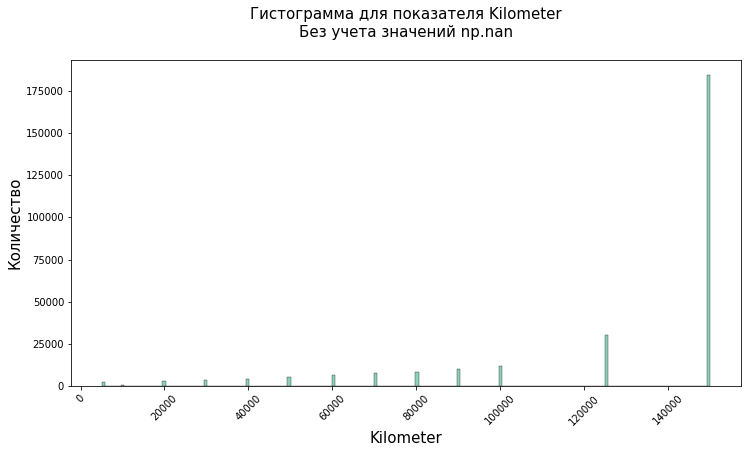

150000    0.661443
125000    0.109033
100000    0.043303
90000     0.035378
80000     0.030866
70000     0.026756
60000     0.023376
50000     0.019421
40000     0.015512
30000     0.013213
20000     0.010788
5000      0.007896
10000     0.003014
Name: Kilometer, dtype: float64
150000    184122
125000     30351
100000     12054
90000       9848
80000       8592
70000       7448
60000       6507
50000       5406
40000       4318
30000       3678
20000       3003
5000        2198
10000        839
Name: Kilometer, dtype: int64




In [63]:
cat_col_analiz(auto_data,'Kilometer')

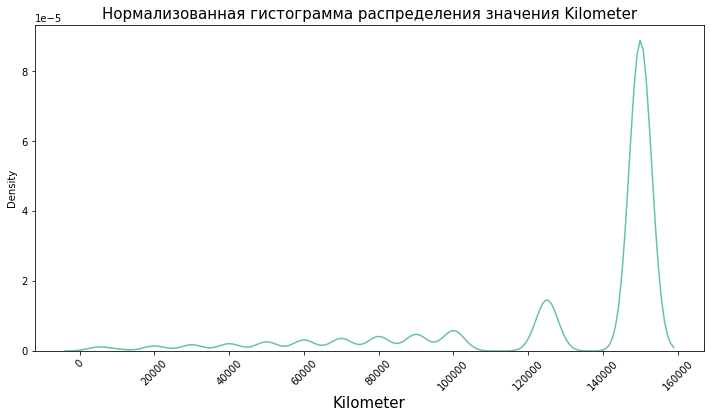

In [64]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.kdeplot(data=auto_data['Kilometer'], common_norm=True);
plt.title(label=f'Нормализованная гистограмма распределения значения Kilometer' , fontsize=15)
plt.xlabel('Kilometer', fontsize=15)
plt.xticks(rotation=45,fontsize=10)
plt.show()

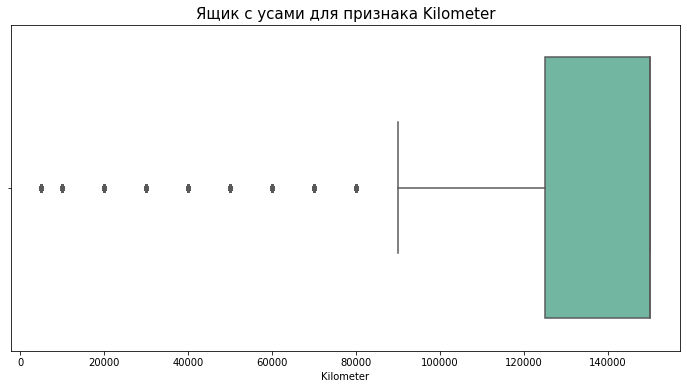

In [65]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.boxplot(x = auto_data['Kilometer']);
plt.title(label=f'Ящик с усами для признака Kilometer', fontsize=15);
plt.show()

Алгоритм выделил все значения километража до 80000 как выбросы. Но у нас нет доказательств, что это скрученный пробег, возможно это новые авто и тд. Оставим как есть.

### Price

In [66]:
auto_data['Price'].describe().T

count    278364.000000
mean       4902.059598
std        4635.770416
min           0.000000
25%        1350.000000
50%        3250.000000
75%        7000.000000
max       20000.000000
Name: Price, dtype: float64

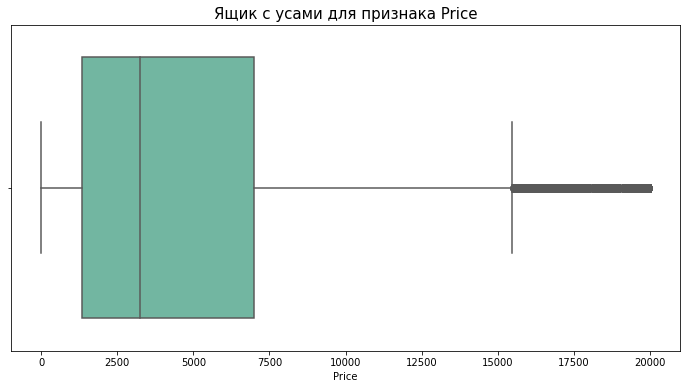

In [67]:
sn.set_palette('Set2')
plt.subplots(figsize=(12, 6))
sn.boxplot(x = auto_data['Price']);
plt.title(label=f'Ящик с усами для признака Price', fontsize=15);
plt.show()

Алгоритм определил как выбросы значения выше 12500. Так же смущают машины стоимостью в 0. Установим минимальную валидную стоимость авто хотя бы в 100 единиц. А по поводу "правых" выбросов, они могут быть не выбросами, а большими желаниями продавцов. Оставим как есть.

In [68]:
price_mask = auto_data['Price'] < 100

In [69]:
auto_data = auto_data.drop(auto_data[price_mask].index)

In [70]:
df_total_size = auto_data.shape[0]

In [71]:
print(f'После обработки аномалий удалено {round((100 - df_total_size / auto_data_size * 100),2)} % данных')

После обработки аномалий удалено 22.94 % данных


### Обработка данных завершена

## 3. Подготовка данных

In [72]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273082 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        273082 non-null  object
 1   Price              273082 non-null  int64 
 2   VehicleType        273082 non-null  object
 3   RegistrationYear   273082 non-null  int64 
 4   Gearbox            273082 non-null  object
 5   Power              273082 non-null  int64 
 6   Model              273082 non-null  object
 7   Kilometer          273082 non-null  int64 
 8   RegistrationMonth  273082 non-null  int64 
 9   FuelType           273082 non-null  object
 10  Brand              273082 non-null  object
 11  Repaired           273082 non-null  object
 12  DateCreated        273082 non-null  object
 13  NumberOfPictures   273082 non-null  int64 
 14  PostalCode         273082 non-null  int64 
 15  LastSeen           273082 non-null  object
dtypes: int64(7), object(

In [73]:
auto_data = auto_data.drop(['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [74]:
auto_data.drop_duplicates(inplace=True, keep='first')

In [75]:
#auto_data = auto_data.drop('Model', axis=1)

In [76]:
#auto_data.drop_duplicates(inplace=True, keep='first')

In [77]:
auto_data = auto_data.drop('RegistrationMonth', axis=1)

In [78]:
auto_data.drop_duplicates(inplace=True, keep='first')

In [79]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233004 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             233004 non-null  int64 
 1   VehicleType       233004 non-null  object
 2   RegistrationYear  233004 non-null  int64 
 3   Gearbox           233004 non-null  object
 4   Power             233004 non-null  int64 
 5   Model             233004 non-null  object
 6   Kilometer         233004 non-null  int64 
 7   FuelType          233004 non-null  object
 8   Brand             233004 non-null  object
 9   Repaired          233004 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.6+ MB


In [80]:
auto_data['Repaired'] = auto_data['Repaired'].apply(lambda x: 1 if x =='yes' else 0)

In [81]:
auto_data['Gearbox'] = auto_data['Gearbox'].apply(lambda x: 1 if x =='auto' else 0)

In [82]:
ohe_col = ['VehicleType','FuelType','Repaired']
mes_col = ['Brand','Model']
pass_col = ['Gearbox']
num_col = ['RegistrationYear','Power','Kilometer']

In [83]:
features.append('Model') #После долгих настроек и тестов, модели с 
                         #признаком Model в датасете показывали на кроссвалидации
                        #лучшую метрику RMSE в среднем на 150 пунктов
                        #а на кроссвалидации при бустинге на 600 пунктов

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(
    auto_data[features],
    auto_data['Price'],
    test_size = VALID_SIZE,
    random_state = RANDOM_STATE)

In [85]:
auto_data[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233004 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233004 non-null  object
 1   RegistrationYear  233004 non-null  int64 
 2   Gearbox           233004 non-null  int64 
 3   Power             233004 non-null  int64 
 4   Kilometer         233004 non-null  int64 
 5   FuelType          233004 non-null  object
 6   Brand             233004 non-null  object
 7   Repaired          233004 non-null  int64 
 8   Model             233004 non-null  object
dtypes: int64(5), object(4)
memory usage: 17.8+ MB


Списки готовы, приступаем к сборке пайплайна

## 4. Обучение моделей

### 4.1 Пайп с простыми моделями

In [86]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [87]:
mes_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'mes', MEstimateEncoder(m=50)
        )
    ]
)

In [88]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('mes', mes_pipe, mes_col),
        ('pas', 'passthrough', pass_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough'
)

In [89]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [90]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     {
        'models': [DecisionTreeRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [91]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring = 'neg_mean_squared_error',  
    n_jobs=-1,
    verbose=2
)

In [92]:
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   1.0s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   1.1s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   1.1s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   1.2s
[CV] END models=LinearRegression(), preprocessor__num=StandardScaler(); total time=   1.8s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   1.0s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   1.1s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   1.1s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   1.1s
[CV] END models=LinearRegression(), preprocessor__num=MinMaxScaler(); total time=   1.1s
[CV] END models=LinearRegression(), prep

In [93]:
score = grid_search.cv_results_['mean_test_score'].min()

In [94]:
best_model_time = round(grid_search.refit_time_,2)

In [95]:
score_no_boost = abs(score)**0.5

In [96]:
print(f'Метрика RMSE для лучшей модели без градиентного бустинга на кроссвалидации равна {score_no_boost}')

Метрика RMSE для лучшей модели без градиентного бустинга на кроссвалидации равна 2634.6482577302936


In [97]:
print(f'Время обучения лучшей модели без градиентного бустинга равно {best_model_time} секунды')

Время обучения лучшей модели без градиентного бустинга равно 1.66 секунды


### 4.2 Поиск по сетке с моделью lightgbm

In [98]:
param_grid_gbm = {
 'learning_rate': [0.1, 0.05],
 'n_estimators': [150 ,100],
 'max_depth': [5,7],
 'num_leaves':[3,5,7]
}

In [99]:
model_gbm = lgm.LGBMRegressor(objective='regression', random_state=RANDOM_STATE)

In [100]:
grid_search_gbm = GridSearchCV(
    model_gbm, 
    param_grid_gbm,
    cv=5,
    scoring = 'neg_mean_squared_error',  
    n_jobs=-1,
    verbose=2
)

In [101]:
ohe_col = ['VehicleType','FuelType','Repaired']
mes_col = ['Brand','Model']
pass_col = ['Gearbox']
num_col = ['RegistrationYear','Power','Kilometer']

In [102]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')

In [103]:
for col in X_valid.select_dtypes(include='object').columns:
    X_valid[col] = X_valid[col].astype('category')

In [104]:
grid_search_gbm.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   3.0s
[CV] END learning_

GridSearchCV(cv=5,
             estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 7],
                         'n_estimators': [150, 100], 'num_leaves': [3, 5, 7]},
             scoring='neg_mean_squared_error', verbose=2)

In [105]:
score_gbm = grid_search_gbm.cv_results_['mean_test_score'].min()

In [106]:
best_model = grid_search_gbm.best_estimator_
print(f"Лучшая модель: {best_model}")
print(f"Гиперпараметры: {grid_search_gbm.cv_results_['params'][grid_search_gbm.best_index_]}")

Лучшая модель: LGBMRegressor(max_depth=7, n_estimators=150, num_leaves=7,
              objective='regression', random_state=42)
Гиперпараметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 7}


In [107]:
best_model_time_gbm = round(grid_search_gbm.refit_time_,2)

In [108]:
score_boost = abs(score_gbm)**0.5

In [109]:
print(f'Метрика RMSE для лучшей модели градиентного бустинга на кроссвалидации равна {score_boost}')

Метрика RMSE для лучшей модели градиентного бустинга на кроссвалидации равна 2150.220574259912


In [110]:
print(f'Время обучения лучшей модели градиентного бустинга равно {best_model_time_gbm} секунды')

Время обучения лучшей модели градиентного бустинга равно 4.1 секунды


**---------------------------------------**

### Модели обучены, получим предсказания моделей, время предсказания и перейдем к анализам результатов

**Лучшая модель без бустинга :**

In [111]:
current_time = time.time()

In [112]:
pred_no_boost = grid_search.best_estimator_.predict(X_valid)

In [113]:
end_time = time.time()

In [114]:
no_boost_time = end_time - current_time

In [115]:
rmse_no_boost = sqrt(mean_squared_error(y_valid, pred_no_boost))

In [116]:
print(f"RMSE модели без бустинга: {rmse_no_boost}")

RMSE модели без бустинга: 1818.0880927299024


In [117]:
print(f"Время предсказания модели без бустинга: {no_boost_time} секунд")

Время предсказания модели без бустинга: 0.08758163452148438 секунд


**Лучшая модель c бустингом :**

In [118]:
current_time = time.time()

In [119]:
pred_boost = grid_search_gbm.best_estimator_.predict(X_valid)

In [120]:
end_time = time.time()

In [121]:
boost_time = end_time - current_time

In [122]:
rmse_boost = sqrt(mean_squared_error(y_valid, pred_boost))

In [123]:
print(f"RMSE модели с бустингом: {rmse_boost}")

RMSE модели с бустингом: 1638.681913865241


In [124]:
print(f"Время предсказания модели без бустинга: {boost_time} секунд")

Время предсказания модели без бустинга: 0.24442672729492188 секунд


## 5. Анализ моделей

**Мы получили 2 лучшие модели, одна без бустинга, вторая с бустингом**

In [125]:
x = ['DecisionTreeRegressor','LGBMRegressor']
y = [score_no_boost,score_boost]
m_times = [best_model_time, best_model_time_gbm]
m_times_pred = [no_boost_time,boost_time]
y_test = [rmse_no_boost,rmse_boost]
boost_stat = [rmse_boost]

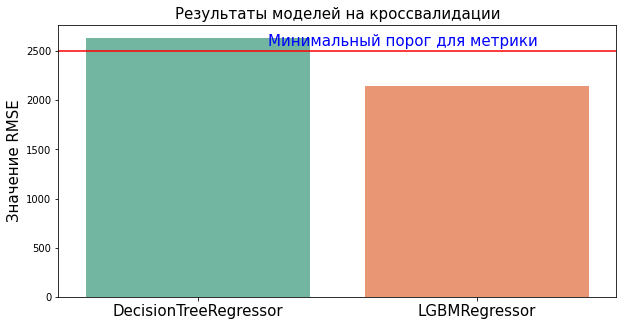

In [126]:
sn.set_palette('Set2')
plt.subplots(figsize=(10, 5))
plt.title(label=f'Результаты моделей на кроссвалидации' , fontsize=15)
plt.ylabel('Значение RMSE', fontsize=15)
plt.xticks(fontsize=15)
sn.barplot(x=x, y=y);
plt.axhline(y=2500, color='r');
plt.text(0.25, 2550, 'Минимальный порог для метрики', fontsize=15, color='b');

**На кроссвалидации модель с бустингом показывает лучшие результаты, и в данном исследовании является единственной, которая пересекла минимальный порог**

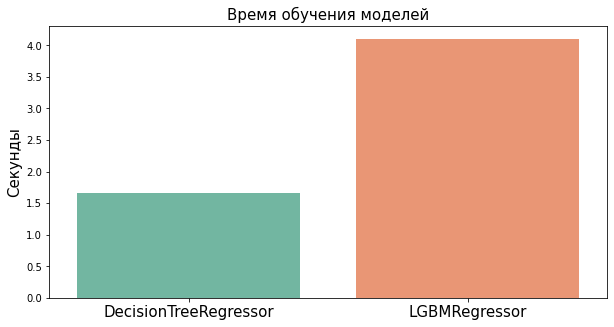

In [127]:
sn.set_palette('Set2')
plt.subplots(figsize=(10, 5))
plt.title(label=f'Время обучения моделей' , fontsize=15)
plt.ylabel('Секунды', fontsize=15)
plt.xticks(fontsize=15)
sn.barplot(x=x, y=m_times);

**Модель с бустингом обучается дольше почти в 3 раза, но при этом показывает намного более точные результаты**

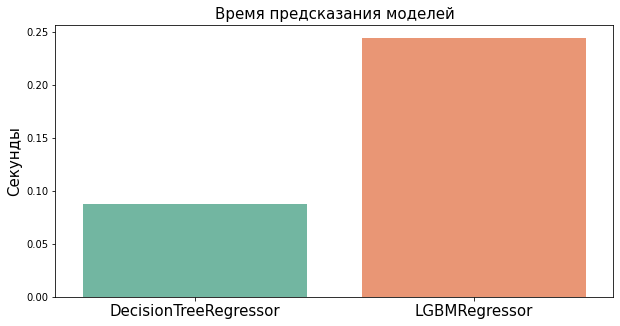

In [128]:
sn.set_palette('Set2')
plt.subplots(figsize=(10, 5))
plt.title(label=f'Время предсказания моделей' , fontsize=15)
plt.ylabel('Секунды', fontsize=15)
plt.xticks(fontsize=15)
sn.barplot(x=x, y=m_times_pred);

**Предсказание модель с бустингом делает так же дольше в 2.5 раза**

**--------------------**

**На обучение и предсказание, модель с бустингом расходует больше времени, но в случае обучения это всего 4 секунды, а предсказания всего 0.4 секунды, что совершенно незначительно, при этом метрика RMSE модели с бустингом намного точнее**

**--------------------**

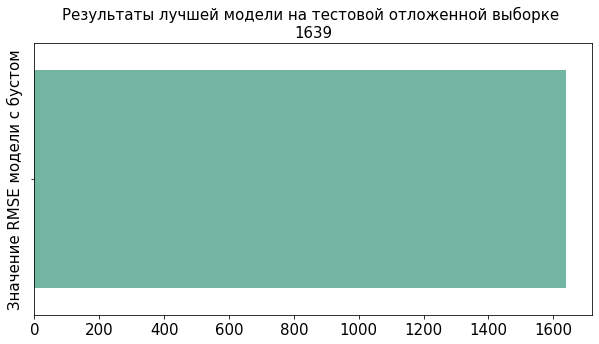

In [129]:
sn.set_palette('Set2')
plt.subplots(figsize=(10, 5))
plt.title(label=f'Результаты лучшей модели на тестовой отложенной выборке \n{round(rmse_boost)}' , fontsize=15)
plt.ylabel('Значение RMSE модели с бустом', fontsize=15)
plt.xticks(fontsize=15)
sn.barplot(x=boost_stat);

**Эффективность метрик выбирается на кроссвалидации, результаты метрик на тесте приведены для заказчика как пример того, насколько точные результаты он мог бы получить в своем конкретном случае**

## 6. Вывод для заказчика

**Были построены модели с бустингом и без. Между ними проведено сравнение. В обоих случая модели обучаются и делают предсказания в незначительные временные промежутки. Максимум 4 секунды. При этом модель с бустингом показывает намного боеле точную метркиу RMSE.**

**На основании исследования заказчику предложено использование модели с градиентным бустингом**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнена загрузка и подготовка данных
- [X]  Выполнено обучение моделей
- [X]  Есть анализ скорости работы и качества моделей